In [1]:
import pandas as pd 
import numpy as np 
from simulation import simulation_erlang as sim
import matplotlib.pyplot as plt
import datetime as dt
import streamlit as st 
import seaborn as sns
from io import BytesIO 
from matplotlib.patches import Patch

## Simulation - Staffing Levels

In [2]:
from scipy.stats import norm
import random
# Generate date range for the entire year
start_date = pd.to_datetime("2024-01-01 00:00:00")
end_date = pd.to_datetime("2024-12-31 23:59:59")
date_range = pd.date_range(start_date, end_date, freq='30T')

# Create DataFrame with random demand values
df = pd.DataFrame(index=date_range)


# Extract date and time separately
df['date'] = df.index.date
df['time'] = df.index.time
index_list = df.index.to_list()

df = df.reset_index()

def assign_group_number(index):
    return index // 16 + 1

# Apply the function to create a new column
df['shift'] = df.index.to_series().apply(assign_group_number)
df.set_index('index', inplace=True)
df['day'] = 1
df.drop(['date', 'time'], axis=1, inplace=True)
demand_df = df
shift_time_dict = {}
for idx, shift in demand_df.iterrows():
    if shift[0] not in shift_time_dict.keys():
        shift_time_dict[shift[0]] = idx
        
demand_df = demand_df.groupby(['shift']).sum()
demand_df['demand'] = demand_df['day'].apply(lambda x: np.random.poisson((1500/365)/3))
demand_df = demand_df.rename(index=shift_time_dict)

C:\Users\Consumer\AppData\Local\Temp\ipykernel_16852\2855733103.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if shift[0] not in shift_time_dict.keys():
C:\Users\Consumer\AppData\Local\Temp\ipykernel_16852\2855733103.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shift_time_dict[shift[0]] = idx


In [3]:
def update_values(row):
    if row['demand'] == 0:
        row['day'] = 2
        row['demand'] = 1
    return row

def reverse_engineer_values(row):
    if row['day'] == 2:
        row.iloc[:-3] = 0
    return row

demand_df = demand_df.apply(update_values, axis=1)


In [4]:
# DEFAULT SCENARIO PARAMETERS - OK 
staffing_levels_df = pd.DataFrame()
handling_times = [0.5,3,7,24,72]

for element in handling_times:
        params = {"service_level" : [0.9],
                "shrinkage" :       [0.4],
                "max_occupancy" :   [0.8],
                "asa" :             [element], # ø-hjelp pr def. er hjelp innen: 30 min, 3t, 7t, 24t, eller 72t
                "aht":              [2],
                'interval':         [24]}

        interval = value = params['interval']
        service_level = value= params["service_level"]
        asa = value = params["asa"]
        aht = value = params["aht"]
        shrinkage = value = params["shrinkage"]
        max_occupancy = value = params["max_occupancy"]
        demand = demand_df.demand


        staffing_levels = sim.compute_staffing_levels(demand = demand,
                                                aht = aht,
                                                asa=asa,
                                                interval=interval,
                                                shrinkage=shrinkage,
                                                service_level=service_level,
                                                max_occupancy=max_occupancy)
        staffing_levels['Month'] = staffing_levels.index.strftime('%B')
        staffing_levels.rename(columns={'Number of surgeries': f'Number of surgeries ({element})',
                   'Raw Staffing Level': f'Raw Staffing Level ({element})',
                   'Staffing Level': f'Staffing Level ({element})',
                   'Service Level (%)': f'Service Level (%) ({element})',
                   'Occupancy (%)': f'Occupancy (%) ({element})',
                   'Waiting Probability (%)': f'Waiting Probability (%) ({element})',
                   'Month': f'Month ({element})'},
          inplace=True, errors='raise')
        staffing_levels_df = pd.concat([staffing_levels_df, staffing_levels], axis=1)

In [5]:
staffing_levels = pd.concat([staffing_levels_df, demand_df], axis=1)
staffing_levels = staffing_levels.apply(reverse_engineer_values, axis=1)
staffing_levels.drop(['day', 'demand'], axis=1, inplace=True)

,Number of surgeries (0.5),Raw Staffing Level (0.5),Staffing Level (0.5),Service Level (%) (0.5),Occupancy (%) (0.5),Waiting Probability (%) (0.5),Month (0.5),Number of surgeries (3),Raw Staffing Level (3),Staffing Level (3),...,Occupancy (%) (24),Waiting Probability (%) (24),Month (24),Number of surgeries (72),Raw Staffing Level (72),Staffing Level (72),Service Level (%) (72),Occupancy (%) (72),Waiting Probability (%) (72),Month (72)
shift,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,1,1,2,93.37,8.33,8.33,January,1,1,2,...,8.33,8.33,January,1,1,2,100.00,8.33,8.33,January
2024-01-01 08:00:00,6,2,4,93.13,25.00,10.00,January,6,2,4,...,25.00,10.00,January,6,2,4,100.00,25.00,10.00,January
2024-01-01 16:00:00,2,2,4,99.19,8.33,1.28,January,2,1,2,...,16.67,16.67,January,2,1,2,100.00,16.67,16.67,January
2024-01-02 00:00:00,1,1,2,93.37,8.33,8.33,January,1,1,2,...,8.33,8.33,January,1,1,2,100.00,8.33,8.33,January
2024-01-02 08:00:00,3,2,4,98.21,12.50,2.78,January,3,1,2,...,25.00,25.00,January,3,1,2,100.00,25.00,25.00,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 08:00:00,0,0,0,0.00,0.00,0.00,0,0,0,0,...,0.00,0.00,0,0,0,0,0.00,0.00,0.00,December
2024-12-30 16:00:00,2,2,4,99.19,8.33,1.28,December,2,1,2,...,16.67,16.67,December,2,1,2,100.00,16.67,16.67,December
2024-12-31 00:00:00,1,1,2,93.37,8.33,8.33,December,1,1,2,...,8.33,8.33,December,1,1,2,100.00,8.33,8.33,December


c:\Users\Consumer\Desktop\projects\NorwegianHealthSector\HealthSector\simulation\simulation_erlang.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_labels = [months[days.index(day)] for day in days if day[8:10] == '01']  # Corresponding month labels


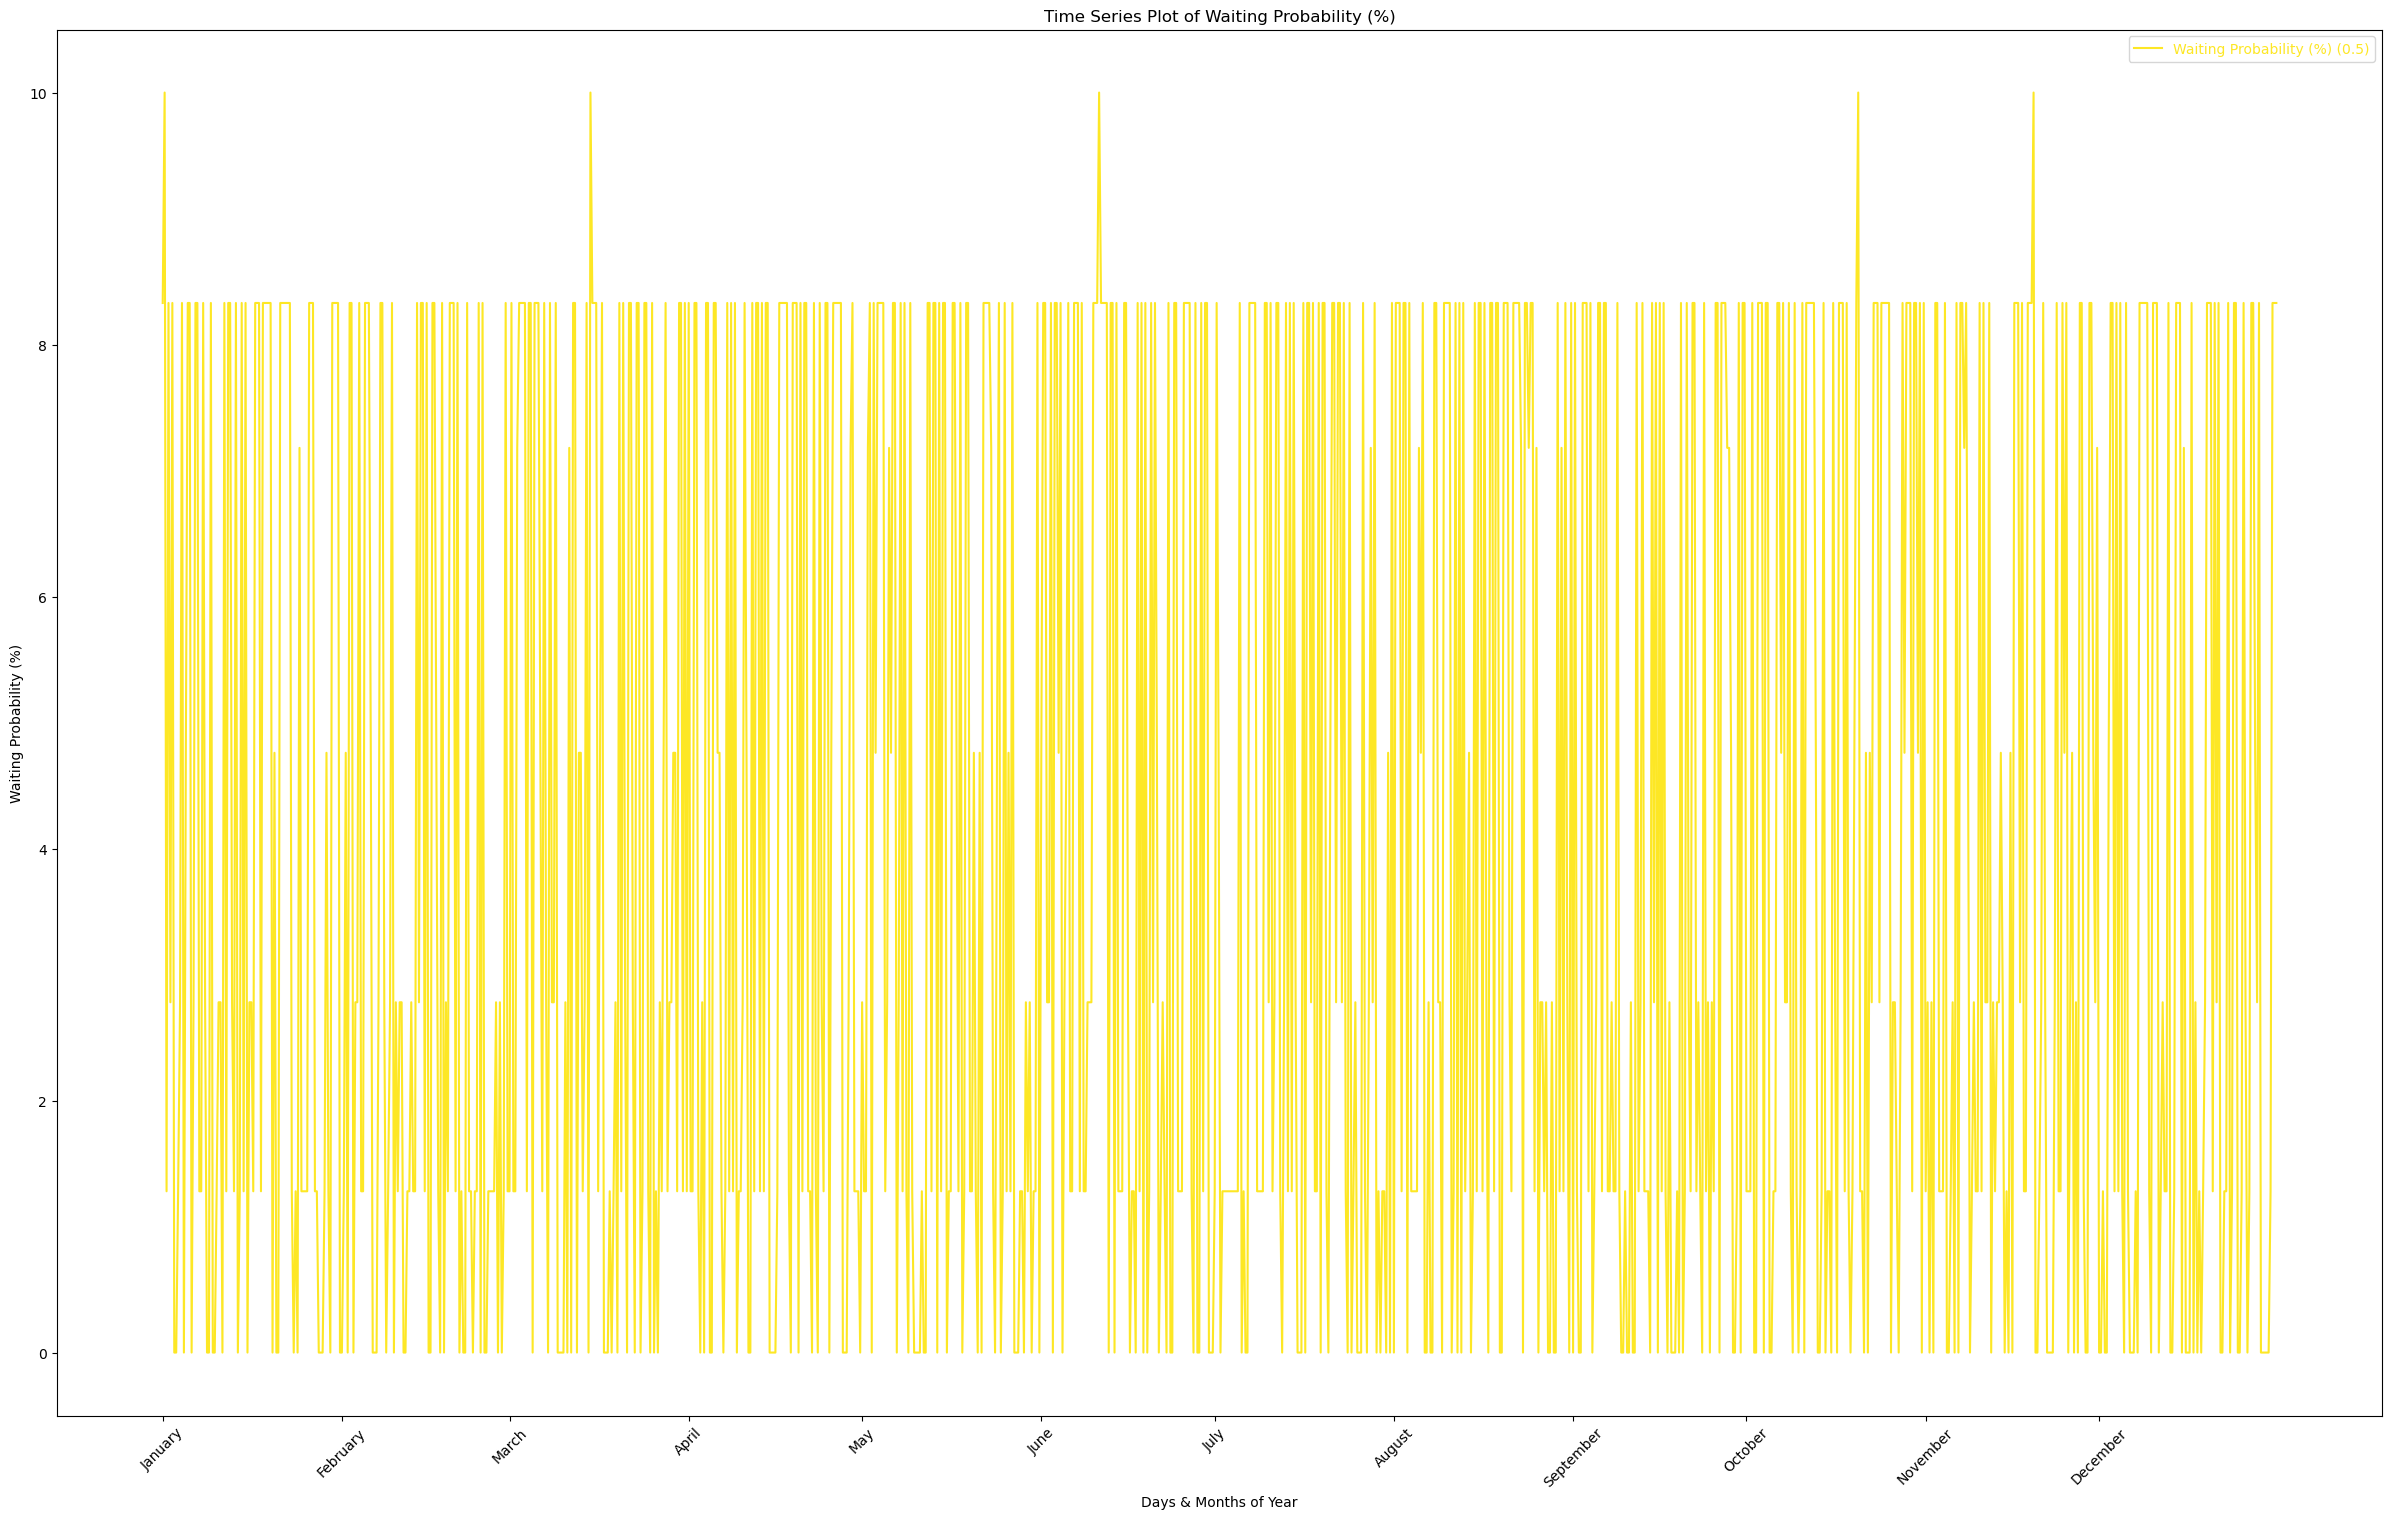

In [10]:
display(staffing_levels)
month = 'All'
observed_kpi = 'Waiting Probability (%)'
aggregation_level = 'year'
handling_times = [0.5]
sim.create_staffing_levels_average_week_plot(staffing_levels=staffing_levels,
                                             month=month, 
                                             observed_kpi=observed_kpi, 
                                             handling_times=handling_times)